## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [38]:
import tensorflow as tf
import keras.backend as K

"""
TO DO:
Write your combined loss
"""
def combined_loss(ce_weight,gamma=2., alpha=4.):
    
    fl_weight=1-ce_weight
    
    gamma = float(gamma)
    alpha = float(alpha)
    def mixed_loss(y_true, y_pred):

        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        if ce_weight==1:
            mixed_loss_ = ce
        else:
            mixed_loss_ = tf.add(tf.multiply(ce_weight, ce), tf.multiply(fl_weight, tf.reduce_mean(reduced_fl)))
        return mixed_loss_
    return mixed_loss

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]
# ce_weights_list = [1]

In [33]:
# import numpy as np
# a=np.array([1,2,3])
# np.add(np.multiply(0, a), np.multiply(0, a))
# np.

array([0, 0, 0])

In [39]:
import itertools
results = {}
keras.backend.clear_session()

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss=combined_loss(ce_w), metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128) 

Epoch 14/25
50000/50000 [==============================] - 1s 24us/step - loss: 1.7092 - acc: 0.6489 - val_loss: 2.7932 - val_acc: 0.4940
Epoch 15/25
50000/50000 [==============================] - 1s 24us/step - loss: 1.6266 - acc: 0.6624 - val_loss: 2.8066 - val_acc: 0.4926
Epoch 16/25
50000/50000 [==============================] - 1s 23us/step - loss: 1.5473 - acc: 0.6797 - val_loss: 2.8127 - val_acc: 0.4869
Epoch 17/25
50000/50000 [==============================] - 1s 23us/step - loss: 1.4797 - acc: 0.6872 - val_loss: 2.8088 - val_acc: 0.4926
Epoch 18/25
50000/50000 [==============================] - 1s 24us/step - loss: 1.4121 - acc: 0.6993 - val_loss: 2.8601 - val_acc: 0.4854
Epoch 19/25
50000/50000 [==============================] - 1s 24us/step - loss: 1.3377 - acc: 0.7124 - val_loss: 2.9087 - val_acc: 0.4840
Epoch 20/25
50000/50000 [==============================] - 1s 24us/step - loss: 1.2726 - acc: 0.7242 - val_loss: 2.9487 - val_acc: 0.4845
Epoch 21/25
50000/50000 [=========

Epoch 2/25
50000/50000 [==============================] - 1s 23us/step - loss: 1.5946 - acc: 0.3989 - val_loss: 1.6988 - val_acc: 0.3728
Epoch 3/25
50000/50000 [==============================] - 1s 23us/step - loss: 1.4409 - acc: 0.4421 - val_loss: 1.5572 - val_acc: 0.4083
Epoch 4/25
50000/50000 [==============================] - 1s 24us/step - loss: 1.3517 - acc: 0.4654 - val_loss: 1.4986 - val_acc: 0.4181
Epoch 5/25
50000/50000 [==============================] - 1s 24us/step - loss: 1.2899 - acc: 0.4858 - val_loss: 1.4348 - val_acc: 0.4370
Epoch 6/25
50000/50000 [==============================] - 1s 23us/step - loss: 1.2368 - acc: 0.5014 - val_loss: 1.3913 - val_acc: 0.4459
Epoch 7/25
50000/50000 [==============================] - 1s 24us/step - loss: 1.1888 - acc: 0.5181 - val_loss: 1.3733 - val_acc: 0.4544
Epoch 8/25
50000/50000 [==============================] - 1s 24us/step - loss: 1.1506 - acc: 0.5297 - val_loss: 1.3655 - val_acc: 0.4535
Epoch 9/25
50000/50000 [=================

In [40]:
results.keys()

dict_keys(['exp-0', 'exp-1', 'exp-2', 'exp-3', 'exp-4'])

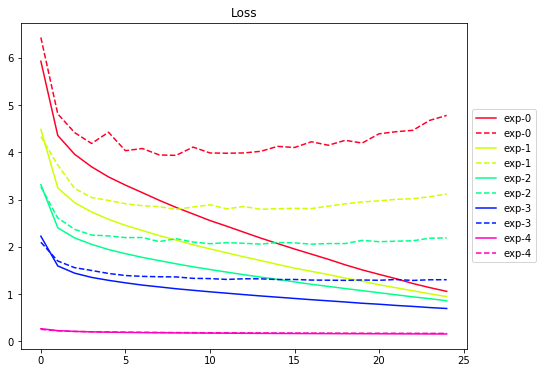

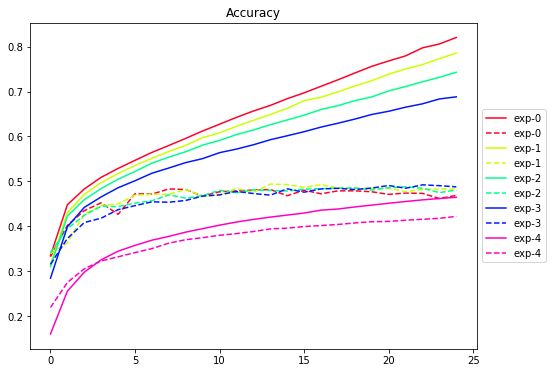

In [41]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()